In [1]:
import tensorflow as tf
import numpy as np
from tqdm import tqdm 
from random import shuffle
import gc
import cv2
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, Activation, Input, Flatten
from tensorflow.keras.optimizers import Adam
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import  accuracy_score, mean_squared_error

imageDir = "UTKFace/"
IMG_SIZE = 160

tf.__version__

C:\Users\a0922\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\a0922\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\a0922\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\a0922\AppData\Roaming\Python\Python37\site-

'2.0.0-beta1'

In [2]:
imgs = os.listdir(imageDir)
imgs[:3], len(imgs)

(['100_0_0_20170112213500903.jpg.chip.jpg',
  '100_0_0_20170112215240346.jpg.chip.jpg',
  '100_1_0_20170110183726390.jpg.chip.jpg'],
 23707)

In [3]:
imgs[0].split('_')[0], imgs[0].split('_')[1], imgs[0].split('_')[2]

('100', '0', '0')

In [9]:
def preprocessing(imageDir):
    #imgs = []
    #ages = []
    #genders = []
    #ethnics = []
    data = []
    for filename in tqdm(os.listdir(imageDir)):
        if len(filename.split('_')) == 4:      
            img = cv2.imread(os.path.join(imageDir + filename))
            img = cv2.resize(img, (IMG_SIZE,IMG_SIZE)).astype('float32')
            img = img.reshape(IMG_SIZE, IMG_SIZE, 3)
            img = img/255.
            age = int(filename.split('_')[0])
            gender = int(filename.split('_')[1])
            ethnic = int(filename.split('_')[2])
            data.append([img, age, gender, ethnic])
            del filename
        #imgs.append(img)
        #ages.append(age)
        #genders.append(gender)
        #ethnics.append(ethnic)
    data = np.array(data)
    shuffle(data)
    imgs = data[:,0]
    ages = np.array(data[:,1])
    genders = np.array(data[:,2])
    ethnics = np.array(data[:,3])
    gc.collect()
    return imgs, ages, genders, ethnics 

In [5]:
def agemodel(inputs, numAges):
    x = Dense(64)(inputs)
    x = LeakyReLU(alpha=0.1)(x)
    x = Dropout(0.2)(x)
    x = Dense(32)(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Dropout(0.2)(x)
    x = Dense(numAges)(x)
    x = Activation('softmax', name='ageoutput')(x)
    return x

In [6]:
def gendermodel(inputs, numGenders):
    x = Dense(64)(inputs)
    x = LeakyReLU(alpha=0.1)(x)
    x = Dropout(0.2)(x)
    x = Dense(32)(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Dropout(0.2)(x)
    x = Dense(numGenders)(x)
    x = Activation('softmax', name='genderoutput')(x)
    return x

In [7]:
def ethnicmodel(inputs, numEthnics):
    x = Dense(64)(inputs)
    x = LeakyReLU(alpha=0.1)(x)
    x = Dropout(0.2)(x)
    x = Dense(32)(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Dropout(0.2)(x)
    x = Dense(numEthnics)(x)
    x = Activation('softmax', name='ethnicoutput')(x)
    return x

In [10]:
imgs, ages, genders, ethnics = preprocessing(imageDir)

100%|██████████| 23707/23707 [08:48<00:00, 44.85it/s]


In [11]:
imgs = np.array([img for img in imgs])

In [12]:
imgs = imgs.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

In [13]:
type(imgs), imgs.shape

(numpy.ndarray, (23705, 160, 160, 3))

In [14]:
numAges = len(np.unique(ages))
numAges, type(ages), ages[100:115], ages.shape

(91,
 numpy.ndarray,
 array([105, 10, 10, 10, 10, 10, 10, 10, 105, 10, 10, 10, 10, 10, 10],
       dtype=object),
 (23705,))

In [15]:
numGenders = len(np.unique(genders))
numGenders, type(genders), genders[100:115]

(2,
 numpy.ndarray,
 array([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], dtype=object))

In [16]:
numEthnics = len(np.unique(ethnics))
numEthnics, type(ethnics), ethnics[100:115]

(5,
 numpy.ndarray,
 array([0, 0, 0, 0, 3, 0, 0, 1, 1, 2, 0, 0, 0, 1, 3], dtype=object))

In [17]:
model_path = '../model/keras/facenet_keras.h5'
face_model = load_model(model_path)

face_model.trainable = False

In [18]:
inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = face_model(inputs)
x = Flatten()(x)
x = Dense(256)(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.2)(x)
x = Dense(128)(x)
x = LeakyReLU(alpha=0.1)(x)
ageBranch = agemodel(x, numAges)
genderBranch = gendermodel(x, numGenders)
ethnicBranch = ethnicmodel(x, numEthnics)

model = Model(inputs=inputs, outputs=[ageBranch, genderBranch, ethnicBranch])


In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
inception_resnet_v1 (Model)     (None, 128)          22808144    input_1[0][0]                    
__________________________________________________________________________________________________
flatten (Flatten)               (None, 128)          0           inception_resnet_v1[1][0]        
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          33024       flatten[0][0]                    
______________________________________________________________________________________________

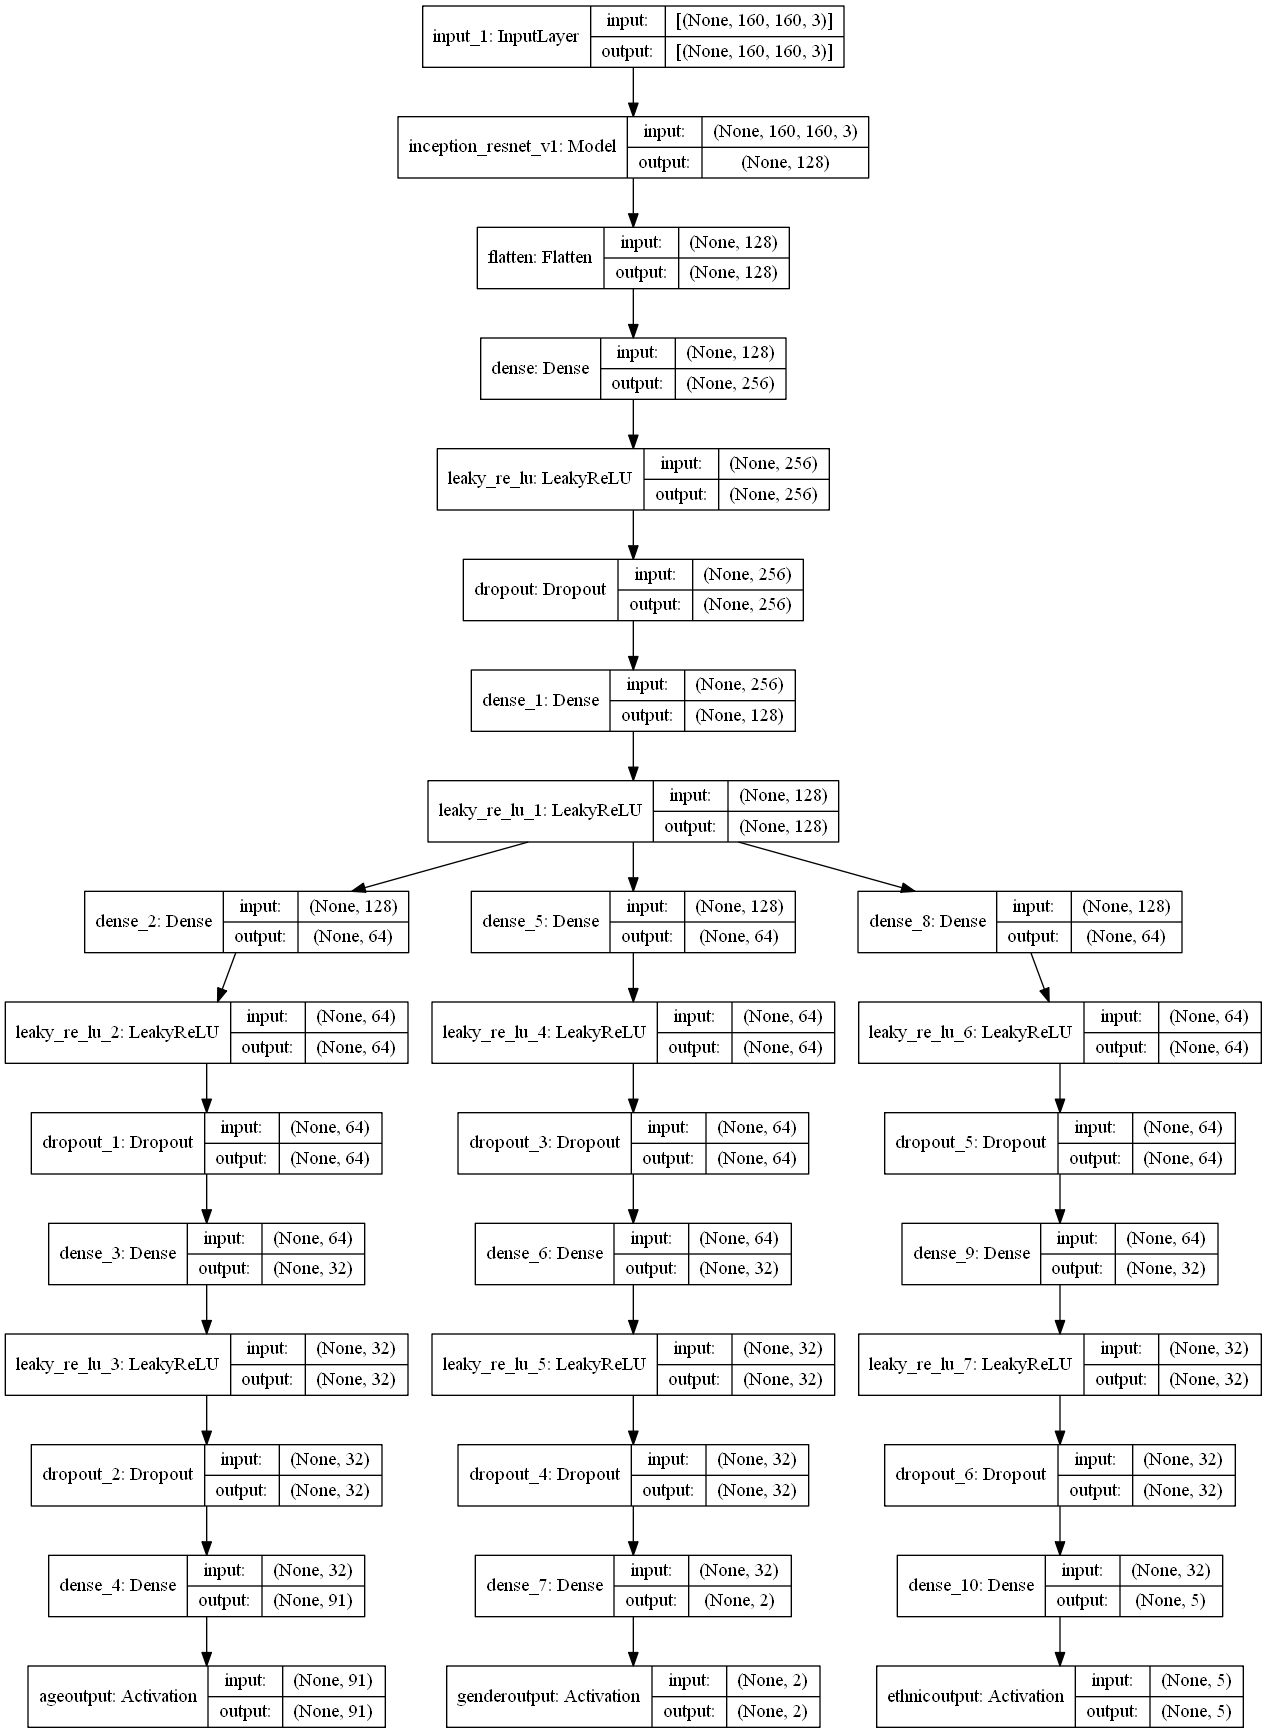

In [20]:
from tensorflow import keras
keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [21]:
model.compile(optimizer='rmsprop' , loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [22]:
gc.collect()

4195

In [24]:
X_train, X_test, agetrain, agetest, gendertrain, gendertest, ethnictrain, ethnictest = train_test_split(imgs, ages, genders, ethnics, test_size=0.2, random_state=42)

MemoryError: Unable to allocate array with shape (18964, 160, 160, 3) and data type float32

In [ ]:
gc.collect()

In [0]:
EPOCHS = 10
model.fit(X_train, 
          {'ageoutput':agetrain, 'genderoutput':gendertrain, 'ethnicoutput':ethnictrain},
          epochs=EPOCHS,
          validation_split=0.2, batch_size=32)

In [0]:
agepred, genderpred, ethnicpred = model.predict(X_test)

In [0]:
ageacc = accuracy_score(agetest, agepred)
ageacc

In [0]:
agemse = mean_squared_error(agetest, agepred)
agemse

In [0]:
genderacc = accuracy_score(gendertest, genderpred)
genderacc

In [0]:
gendermse = mean_squared_error(gendertest, genderpred)
gendermse

In [0]:
ethnicacc = accuracy_score(ethnictest, ethnicpred)
ethnicacc

In [0]:
ethnicmse = mean_squared_error(ethnictest, ethnicpred)
ethnicmse